#*Masked Face Classification With Transfer Learning*

#Graphics

In [ ]:
!nvidia-smi

#Import Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Moving Data

In [ ]:
%cp -R /content/drive/MyDrive/Face_Masked_Dataset/ /content/

### Building the Image Dataset

In [ ]:
import os

Now, let's see what the filenames look like in the `Faces` and `Masked Faces` training directories:





In [ ]:
train_faces_names = os.listdir('/content/Face_Masked_Dataset/Train/Faces')
print(train_faces_names[:10])

train_masked_names = os.listdir('/content/Face_Masked_Dataset/Train/Masked')
print(train_masked_names[:10])

validation_faces_hames = os.listdir('/content/Face_Masked_Dataset/validation/Faces')
print(validation_faces_hames[:10])

validation_masked_names = os.listdir('/content/Face_Masked_Dataset/validation/Masked')
print(validation_masked_names[:10])

['01937.png', '01351.png', '01580.png', '01630.png', '01325.png', '01168.png', '00465.png', '01803.png', '01856.png', '00703.png']
['46808_Mask.jpg', '46409_Mask.jpg', 'nji (149).jpg', '46311_Mask.jpg', '46744_Mask.jpg', 'gsf (5).jpg', 'nji (441).jpg', 'nji (801).jpg', '46424_Mask.jpg', 'nji (328).jpg']
['00273.png', '00251.png', '00047.png', '00297.png', '00002.png', '00227.png', '00267.png', '00120.png', '00269.png', '00279.png']
['xd (7).jpg', '46094_Mask.jpg', '54 (2).jpg', 'xd (3).jpg', '46085_Mask.jpg', '46023_Mask.jpg', '46194_Mask.jpg', '46201_Mask.jpg', '46004_Mask.jpg', '46206_Mask.jpg']


Let's find out the total number of faces and masked faces images in the directories:

In [ ]:
# Directory with our training faces pictures
train_faces_dir = os.path.join('/content/Face_Masked_Dataset/Train/Faces')

# Directory with our training masked pictures
train_masked_dir = os.path.join('/content/Face_Masked_Dataset/Train/Masked')

# Directory with our validation faces pictures
valid_faces_dir = os.path.join('/content/Face_Masked_Dataset/validation/Faces')

# Directory with our validation masked pictures
valid_masked_dir = os.path.join('/content/Face_Masked_Dataset/validation/Masked')

In [ ]:
print('total training faces images:', len(os.listdir(train_faces_dir)))
print('total training masked images:', len(os.listdir(train_masked_dir)))
print('total validation faces images:', len(os.listdir(valid_faces_dir)))
print('total validation masked images:', len(os.listdir(valid_masked_dir)))

total training dandelion images: 1709
total training grass images: 1930
total validation dandelion images: 304
total validation grass images: 300


Now let's take a look at a few pictures to get a better sense of what they look like. First, configure the matplot parameters:

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

Now, display a batch of 8 faces and 8 masked pictures. You can rerun the cell to see a fresh batch each time:

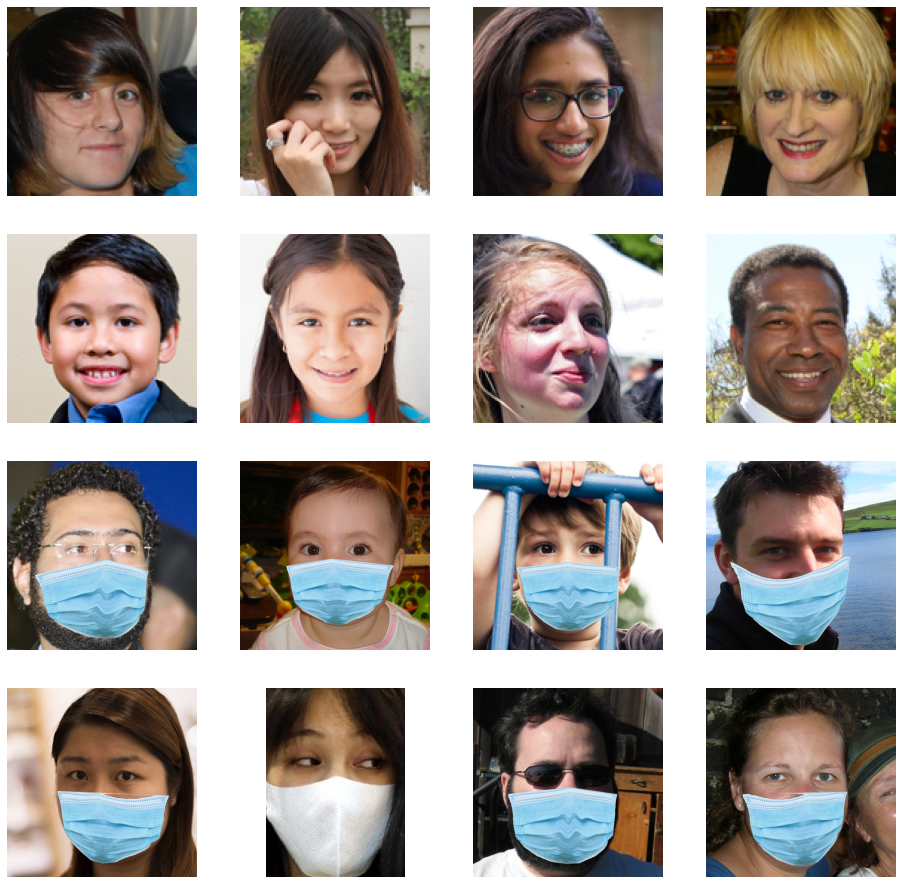

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_faces_pic = [os.path.join(train_faces_dir, fname) 
                for fname in train_faces_names[pic_index-8:pic_index]]
next_masked_pic = [os.path.join(train_masked_dir, fname) 
                for fname in train_masked_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_faces_pic + next_masked_pic):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


#### Data Preprocessing

Now ,let's use `keras.preprocessing.image.ImageDataGenerator` class to create our train and validation dataset and normalize our data. 

It's important to normalize our data because data going into our CNN to improve its overall performance. We will use the `rescale` parameter to scale our image pixel values from [0, 255] to [0,1].

In each generator, we specify the source directory of our images, the classes, the input image size, the batch size (how many images to process at once), and class mode.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 120 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/content/Face_Masked_Dataset/Train/',  # This is the source directory for training images
        classes = ['Faces', 'Masked'],
        target_size=(120, 120),  # All images will be resized to 200x200
        batch_size=120,
        # Use binary labels
        class_mode='binary')

# Flow validation images in batches of 19 using valid_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        '/content/Face_Masked_Dataset/validation/',  # This is the source directory for training images
        classes = ['Faces', 'Masked'],
        target_size=(120, 120),  # All images will be resized to 200x200
        batch_size=19,
        # Use binary labels
        class_mode='binary',
        shuffle=False)

Found 3639 images belonging to 2 classes.
Found 604 images belonging to 2 classes.


## Building the Model

But before we continue, let's start defining the model:

Step 1 will be to import tensorflow and the libraries we need:

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
import numpy as np
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

Now, let's add the MobileNet model. Make sure that to include the include_top parameter and set to to False. This will subtract the last layer of the model, so that we can add our own layer that we will train on. This is called transfer learning! For that last layer, we will add a Sigmoid layer for binary classification.

In [ ]:
model = Sequential()
model.add(MobileNetV2(include_top = False, weights="imagenet", input_shape=(120, 120, 3)))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(1, activation = 'sigmoid'))
model.layers[0].trainable = False


The model.summary() method call prints a summary of the NN 

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


The "output shape" column shows the transformation of the dimensions of each layer as a result of the convolution and max pooling - convolution will reduce the layer size by a bit due to padding, and max pooling will halve the output size.

In [ ]:
from tensorflow.keras.optimizers import RMSprop

# model.compile(loss='binary_crossentropy',
#               optimizer=RMSprop(lr=0.001),
#               metrics=['accuracy', tf.keras.metrics.AUC()])

from tensorflow.keras import optimizers


model.compile(optimizer=RMSprop(lr=0.01), loss = 'binary_crossentropy', metrics = 'accuracy')

### Training
Let's train for 15 epochs -- this may take a few minutes to run.

Note that steps_per_epoch was set along with batch_size in ImageDataGenerator so that steps_per_epoch * batch_size = total # of images. For example, for training, 8 * 120 = 960, just under our total of 999 images.

Notice that as we train, our validation accuracy never exceeds training accuracy, which is a good thing. Our model won't work better on unseen images than seen images.

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=8,  
      epochs=15,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8)

Epoch 1/15
8/8 [==============================] - 12s 1s/step - loss: 1.9366 - accuracy: 0.7204 - val_loss: 0.0145 - val_accuracy: 1.0000
Epoch 2/15
8/8 [==============================] - 9s 1s/step - loss: 0.0334 - accuracy: 0.9838 - val_loss: 0.0041 - val_accuracy: 1.0000
Epoch 3/15
8/8 [==============================] - 9s 1s/step - loss: 0.0156 - accuracy: 0.9952 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 4/15
8/8 [==============================] - 8s 973ms/step - loss: 0.0094 - accuracy: 0.9996 - val_loss: 0.0221 - val_accuracy: 0.9934
Epoch 5/15
8/8 [==============================] - 9s 1s/step - loss: 0.3218 - accuracy: 0.9476 - val_loss: 1.2428e-04 - val_accuracy: 1.0000
Epoch 6/15
8/8 [==============================] - 9s 1s/step - loss: 0.0096 - accuracy: 0.9983 - val_loss: 4.4755e-04 - val_accuracy: 1.0000
Epoch 7/15
8/8 [==============================] - 9s 1s/step - loss: 0.0069 - accuracy: 0.9961 - val_loss: 6.6748e-04 - val_accuracy: 1.0000
Epoch 8/15
8/8 [=========

## Accuracy, ROC Curve, and AUC

Let's evaluate the accuracy of our model:

In [ ]:
model.evaluate(validation_generator)

32/32 [==============================] - 5s 161ms/step - loss: 0.0083 - accuracy: 0.9967


[0.008294213563203812, 0.996688723564148]

Now, let's calculate our ROC curve and plot it.

First, let's make predictions on our validation set. When using generators to make predictions, we must first turn off shuffle (as we did when we created validation_generator) and reset the generator:

In [ ]:
STEP_SIZE_TEST=validation_generator.n//validation_generator.batch_size
validation_generator.reset()
preds = model.predict(validation_generator,
                      verbose=1)

32/32 [==============================] - 5s 152ms/step


To create the ROC curve and AUC, we'll need to compute the false-positive rate and the true-positive rate:

In [ ]:
fpr, tpr, _ = roc_curve(validation_generator.classes, preds)

In [ ]:
roc_auc = auc(fpr, tpr)

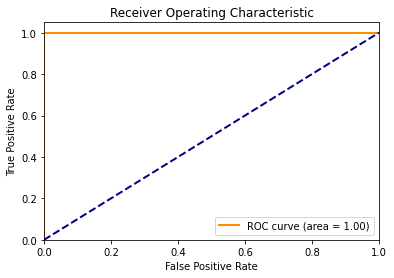

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

The ROC curve is a probability curve plotting the true-positive rate (TPR) against the false-positive rate (FPR). In this curve, the diagonal line is the curve for random guessing, e.g. coin flipping, so the ROC curve above shows that our model does much better than chance at classifying between faces and masked faces. Not bad!

Similarly, the AUC (area under curve), as shown in the legend above, measures how much our model is capable of distinguishing between our two classes, faces and masked faces. The higher the AUC, the better our model is at classification. It is also used to compare different models, which I will do in future tutorials when I present how to build an image classifier using full-connected layers and also transfer learning with ResNet!

###Making Predictions

Now, let's use the modlel to make predictions! Upload an image to see if it's a face or masked face.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(120, 120))
  x = image.img_to_array(img)
  plt.imshow(x/255.)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]<0.5:
    print(fn + " is a face")
  else:
    print(fn + " is a masked face")
 